<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
# Data modules.
import numpy as np
import scipy.stats as stats
import pandas as pd

# Plotting modules.
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Stats/regressions packages.
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Make sure charts appear in the notebook.
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Hide warnings.
import warnings
warnings.filterwarnings('ignore')

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

## Guiding Questions for Data Cleaning

* There are too many features. How do we group them into two groups - fixed and renovatable?
* Which features are relevant and will help us achieve our goals?
* How do we deal with null values and columns with mostly null values?
* How imbalanced is the dataset?
* Are there non-residential data in the dataset?


</div>

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
house.shape

(1460, 81)

In [4]:
# Remove ellipses and display all features.
pd.options.display.max_columns=2000
house.head(3)
# house

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


## Skewed Data, Null & Unnecessary Columns

In [5]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [6]:
# Find out which columns contain more than 80% null values.
null_check = house.columns[house.isna().any()].tolist()
print("Columns to drop:")
for col in null_check:
    missing = 0
    missing = (house[col].isnull().sum()/1460) *100
    if (missing > 80):
        print(col)

Columns to drop:
Alley
PoolQC
Fence
MiscFeature


In [7]:
house["Heating"].value_counts()

GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

In [8]:
house["CentralAir"].value_counts()

Y    1365
N      95
Name: CentralAir, dtype: int64

In [9]:
house["RoofMatl"].value_counts()

CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Membran       1
Metal         1
Roll          1
ClyTile       1
Name: RoofMatl, dtype: int64

In [10]:
house["MiscVal"].value_counts()

0        1408
400        11
500         8
700         5
450         4
2000        4
600         4
1200        2
480         2
1150        1
800         1
15500       1
620         1
3500        1
560         1
2500        1
1300        1
1400        1
350         1
8300        1
54          1
Name: MiscVal, dtype: int64

In [11]:
house["Street"].value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

In [12]:
house["Utilities"].value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [13]:
house["LandSlope"].value_counts()

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

In [14]:
house["Condition1"].value_counts()

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

In [15]:
house["Condition2"].value_counts()

Norm      1445
Feedr        6
PosN         2
RRNn         2
Artery       2
RRAn         1
RRAe         1
PosA         1
Name: Condition2, dtype: int64

## Observations

* Four columns contained mostly null values - Alley, PoolQC, Fence and MiscFeature.
* Nine more columns had value_counts skewed to one class - Street, Utilities, LandSlope, Condition1, Condition2, Heating, CentralAir, RoofMatl, MiscVal.
* There were more columns which did not make sense.
* Hence, we will drop these features from the dataset.
</div>

In [16]:
# Drop the four mostly null columns.
house.drop(['Alley', "PoolQC", "Fence", "MiscFeature", "Street", "Utilities", "LandSlope",
            "Condition1", "Condition2", "Heating", "CentralAir", "RoofMatl", "MiscVal"], 
                   axis=1, inplace=True)

In [17]:
# Drop additional columns as they are unnecessary or do not make sense.
house.drop(["Id", "OverallQual", "OverallCond", "YearBuilt", "YearRemodAdd",
            "GarageYrBlt", "MoSold", 'KitchenAbvGr', "BedroomAbvGr", "TotRmsAbvGrd",
           "GrLivArea"],
           axis=1, inplace=True)

In [18]:
# Check if the columns have been dropped.
house.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LandContour', 'LotConfig', 'Neighborhood', 'BldgType', 'HouseStyle',
       'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'KitchenQual', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'YrSold',
       'SaleType', 'SaleCondition', 'SalePrice'],
      dtype='object')

## Drop Non-Residential Rows

In [19]:
# Check for non-residential data.
house["MSZoning"].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [20]:
house[house["MSZoning"] == "C (all)"]

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,Neighborhood,BldgType,HouseStyle,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,YrSold,SaleType,SaleCondition,SalePrice
30,70,C (all),50.0,8500,Reg,Lvl,Inside,IDOTRR,1Fam,2Story,Gambrel,BrkFace,BrkFace,None,0.0,TA,Fa,BrkTil,TA,TA,No,Unf,0,Unf,0,649,649,TA,SBrkr,649,668,0,0,0,1,0,TA,Typ,0,NaN,Detchd,Unf,1,250,TA,Fa,N,0,54,172,0,0,0,2008,WD,Normal,40000
88,50,C (all),105.0,8470,IR1,Lvl,Corner,IDOTRR,1Fam,1.5Fin,Hip,Plywood,Plywood,None,0.0,Fa,Fa,CBlock,TA,Fa,No,Unf,0,Unf,0,1013,1013,TA,SBrkr,1013,0,513,0,0,1,0,Fa,Typ,0,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,156,0,0,0,2009,ConLD,Abnorml,85000
93,190,C (all),60.0,7200,Reg,Lvl,Corner,OldTown,2fmCon,2.5Unf,Hip,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,Fa,Mn,Rec,1046,Unf,0,168,1214,Ex,SBrkr,1260,1031,0,0,1,2,0,TA,Typ,1,Gd,Detchd,Unf,2,506,TA,TA,Y,0,0,0,0,99,0,2007,WD,Normal,133900
495,30,C (all),60.0,7879,Reg,Lvl,Inside,IDOTRR,1Fam,1Story,Gable,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,495,Unf,0,225,720,TA,FuseA,720,0,0,0,0,1,0,TA,Typ,0,NaN,NaN,NaN,0,0,NaN,NaN,N,0,523,115,0,0,0,2009,WD,Abnorml,34900
557,50,C (all),60.0,11040,Reg,Low,Inside,IDOTRR,1Fam,1.5Fin,Gable,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,637,Unf,0,0,637,Gd,SBrkr,897,439,0,0,0,1,1,TA,Typ,0,NaN,CarPort,Unf,1,570,TA,TA,Y,0,47,120,0,0,0,2006,COD,Normal,108000
711,50,C (all),66.0,8712,Reg,HLS,Inside,IDOTRR,1Fam,1.5Fin,Gable,MetalSd,MetalSd,None,0.0,TA,TA,Stone,TA,TA,Mn,Unf,0,Unf,0,859,859,Gd,SBrkr,859,319,0,0,0,1,0,TA,Typ,0,NaN,Detchd,RFn,1,384,TA,TA,N,68,0,98,0,0,0,2010,WD,Abnorml,102776
812,20,C (all),66.0,8712,Reg,Bnk,Inside,IDOTRR,1Fam,1Story,Hip,Wd Sdng,Wd Sdng,None,0.0,Fa,TA,CBlock,TA,TA,Av,Unf,0,Unf,0,540,540,TA,FuseA,1044,0,0,0,0,1,0,Fa,Typ,0,NaN,Basment,Unf,2,504,TA,TA,N,0,0,0,0,0,0,2010,WD,Alloca,55993
916,20,C (all),50.0,9000,Reg,Lvl,Inside,IDOTRR,1Fam,1Story,Gable,AsbShng,AsbShng,None,0.0,TA,TA,CBlock,TA,TA,Av,BLQ,50,Unf,0,430,480,TA,FuseA,480,0,0,1,0,0,0,TA,Typ,0,NaN,Detchd,Unf,1,308,TA,TA,Y,0,0,0,0,0,0,2006,WD,Abnorml,35311
1061,30,C (all),120.0,18000,Reg,Low,Inside,IDOTRR,1Fam,1Story,Gable,MetalSd,MetalSd,None,0.0,Fa,TA,CBlock,TA,TA,No,Unf,0,Unf,0,894,894,TA,SBrkr,894,0,0,0,0,1,0,TA,Typ,0,NaN,Detchd,RFn,3,1248,TA,TA,Y,0,20,0,0,0,0,2008,ConLD,Normal,81000
1279,50,C (all),60.0,7500,Reg,Lvl,Inside,IDOTRR,1Fam,1.5Fin,Gable,MetalSd,MetalSd,None,0.0,TA,Gd,CBlock,TA,TA,No,Unf,0,Unf,0,698,698,TA,FuseA,698,430,0,0,0,1,0,TA,Typ,0,NaN,Detchd,RFn,2,528,TA,TA,Y,30,0,164,0,0,0,2010,COD,Abnorml,68400


In [21]:
# We'll remove the commercial units from the dataset.
house.drop(house.index[[30, 88, 93, 495, 557, 711, 812, 916, 1061, 1279]], inplace=True)

In [22]:
# Check for any more non-residential properties.
house[house["MSZoning"] == "C (all)"]

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,Neighborhood,BldgType,HouseStyle,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,YrSold,SaleType,SaleCondition,SalePrice


## Dummify Categorical Columns

In [23]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 57 columns):
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
LotShape         1450 non-null object
LandContour      1450 non-null object
LotConfig        1450 non-null object
Neighborhood     1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
RoofStyle        1450 non-null object
Exterior1st      1450 non-null object
Exterior2nd      1450 non-null object
MasVnrType       1442 non-null object
MasVnrArea       1442 non-null float64
ExterQual        1450 non-null object
ExterCond        1450 non-null object
Foundation       1450 non-null object
BsmtQual         1413 non-null object
BsmtCond         1413 non-null object
BsmtExposure     1412 non-null object
BsmtFinType1     1413 non-null object
BsmtFinSF1       1450 non-null int64
BsmtFinType2     141

In [24]:
# Convert the features to string so that they can be dummified.
house["MSSubClass"] = house["MSSubClass"].astype(str)
house["Fireplaces"] = house["Fireplaces"].astype(str)
house["GarageCars"] = house["GarageCars"].astype(str)

In [25]:
dummies = pd.get_dummies(house[["MSZoning", "LotShape", "LandContour", "LotConfig", "Neighborhood",
                "BldgType", "HouseStyle", "RoofStyle", "Exterior1st", "Exterior2nd",
                "MasVnrType", "ExterQual", "ExterCond", "Foundation", "BsmtQual",
                "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC",
                "Electrical", "KitchenQual", "Functional", "FireplaceQu", "GarageType", 
                "GarageFinish", "GarageQual", "GarageCond", "PavedDrive", "SaleType",
                "SaleCondition", "MSSubClass", "Fireplaces", "GarageCars"]], drop_first = True)

In [26]:
# Merge the DataFrame result back onto the original dataframe.
house = house.merge(dummies, left_index = True, right_index = True,how = 'outer')

In [27]:
# We can now drop the original columns.
house.drop(["MSZoning", "LotShape", "LandContour", "LotConfig", "Neighborhood",
                "BldgType", "HouseStyle", "RoofStyle", "Exterior1st", "Exterior2nd",
                "MasVnrType", "ExterQual", "ExterCond", "Foundation", "BsmtQual",
                "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC",
                "Electrical", "KitchenQual", "Functional", "FireplaceQu", "GarageType", 
                "GarageFinish", "GarageQual", "GarageCond", "PavedDrive", "SaleType",
                "SaleCondition", "MSSubClass", "Fireplaces",
                "GarageCars"], axis = 1, inplace = True)

In [28]:
house.head(3)

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,YrSold,SalePrice,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,Fireplaces_1,Fireplaces_2,Fireplaces_3,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4
0,65.0,8450,196.0,706,0,150,856,856,854,0,1,0,2,1,548,0,61,0,0,0,0,2008,208500,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,80.0,9600,0.0,978,0,284,1262,1262,0,0,0,1,2,0,460,298,0,0,0,0,0,2007,181500,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1

## Null Values

In [29]:
# Check for null values.
house.isnull().sum()

LotFrontage              259
LotArea                    0
MasVnrArea                 8
BsmtFinSF1                 0
BsmtFinSF2                 0
BsmtUnfSF                  0
TotalBsmtSF                0
1stFlrSF                   0
2ndFlrSF                   0
LowQualFinSF               0
BsmtFullBath               0
BsmtHalfBath               0
FullBath                   0
HalfBath                   0
GarageArea                 0
WoodDeckSF                 0
OpenPorchSF                0
EnclosedPorch              0
3SsnPorch                  0
ScreenPorch                0
PoolArea                   0
YrSold                     0
SalePrice                  0
MSZoning_RH                0
MSZoning_RL                0
MSZoning_RM                0
LotShape_IR2               0
LotShape_IR3               0
LotShape_Reg               0
LandContour_HLS            0
                        ... 
SaleType_ConLw             0
SaleType_New               0
SaleType_Oth               0
SaleType_WD   

In [30]:
house.describe()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,YrSold,SalePrice,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unf,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,Fireplaces_1,Fireplaces_2,Fireplaces_3,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4
count,1191.000000,1450.000000,1442.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,

In [31]:
# Fill the null values with the mean(70).
house['LotFrontage'] = house['LotFrontage'].fillna(70)

# Fill the eight null values with 0.
house['MasVnrArea'] = house['MasVnrArea'].fillna(0)

In [32]:
# Check for any more null values.
house.isnull().any()

LotFrontage              False
LotArea                  False
MasVnrArea               False
BsmtFinSF1               False
BsmtFinSF2               False
BsmtUnfSF                False
TotalBsmtSF              False
1stFlrSF                 False
2ndFlrSF                 False
LowQualFinSF             False
BsmtFullBath             False
BsmtHalfBath             False
FullBath                 False
HalfBath                 False
GarageArea               False
WoodDeckSF               False
OpenPorchSF              False
EnclosedPorch            False
3SsnPorch                False
ScreenPorch              False
PoolArea                 False
YrSold                   False
SalePrice                False
MSZoning_RH              False
MSZoning_RL              False
MSZoning_RM              False
LotShape_IR2             False
LotShape_IR3             False
LotShape_Reg             False
LandContour_HLS          False
                         ...  
SaleType_ConLw           False
SaleType

## Possible Fixed Features for Modelling

In [33]:
house_f = house[["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", 
                 "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF",
                "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath", # This line has 4 features.
                "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch",
                "ScreenPorch", "PoolArea", "YrSold", "SalePrice", "MSZoning_RH",
                "MSZoning_RL", "MSZoning_RM", "LotShape_IR2", "LotShape_IR3", "LotShape_Reg",
                "LandContour_HLS", "LandContour_Low", "LandContour_Lvl", "LotConfig_CulDSac", "LotConfig_FR2",
                "LotConfig_FR3", "LotConfig_Inside", "Neighborhood_Blueste", "Neighborhood_BrDale", "Neighborhood_BrkSide",
                "Neighborhood_ClearCr", "Neighborhood_CollgCr", "Neighborhood_Crawfor", "Neighborhood_Edwards", "Neighborhood_Gilbert",
                "Neighborhood_IDOTRR", "Neighborhood_MeadowV", "Neighborhood_Mitchel", "Neighborhood_NAmes", "Neighborhood_NPkVill",
                "Neighborhood_NWAmes", "Neighborhood_NoRidge", "Neighborhood_NridgHt", "Neighborhood_OldTown", "Neighborhood_SWISU",
                "Neighborhood_Sawyer", "Neighborhood_SawyerW", "Neighborhood_Somerst", "Neighborhood_StoneBr", "Neighborhood_Timber",
                "Neighborhood_Veenker", "BldgType_2fmCon", "BldgType_Duplex", "BldgType_Twnhs", "BldgType_TwnhsE",
                "HouseStyle_1.5Unf", "HouseStyle_1Story", "HouseStyle_2.5Fin", "HouseStyle_2.5Unf", "HouseStyle_2Story",
                "HouseStyle_SFoyer", "HouseStyle_SLvl", "RoofStyle_Gable", "RoofStyle_Gambrel", "RoofStyle_Hip",
                "RoofStyle_Mansard", "RoofStyle_Shed", "Exterior1st_AsphShn", "Exterior1st_BrkComm", "Exterior1st_BrkFace",
                "Exterior1st_CBlock", "Exterior1st_CemntBd", "Exterior1st_HdBoard", "Exterior1st_ImStucc", "Exterior1st_MetalSd",
                "Exterior1st_Plywood", "Exterior1st_Stone", "Exterior1st_Stucco", "Exterior1st_VinylSd", "Exterior1st_Wd Sdng",
                "Exterior1st_WdShing", "Exterior2nd_AsphShn", "Exterior2nd_Brk Cmn", "Exterior2nd_BrkFace", "Exterior2nd_CBlock",
                "Exterior2nd_CmentBd", "Exterior2nd_HdBoard", "Exterior2nd_ImStucc", "Exterior2nd_MetalSd", "Exterior2nd_Other",
                "Exterior2nd_Plywood", "Exterior2nd_Stone", "Exterior2nd_Stucco", "Exterior2nd_VinylSd", "Exterior2nd_Wd Sdng",
                "Exterior2nd_Wd Shng", "MasVnrType_BrkFace", "MasVnrType_None", "MasVnrType_Stone", "ExterQual_Fa",
                "ExterQual_Gd", "ExterQual_TA", "ExterCond_Fa", "ExterCond_Gd", "ExterCond_Po",
                "ExterCond_TA", "Foundation_CBlock", "Foundation_PConc", "Foundation_Slab", "Foundation_Stone",
                "Foundation_Wood"]]

In [34]:
house_f.head(3)

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,YrSold,SalePrice,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood
0,65.0,8450,196.0,706,0,150,856,856,854,0,1,0,2,1,548,0,61,0,0,0,0,2008,208500,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0
1,80.0,9600,0.0,978,0,284,1262,1262,0,0,0,1,2,0,460,298,0,0,0,0,0,2007,181500,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0
2,68.0,11250,162.0,486,0,434,920,920,866,0,1,0,2,1,608,0,42,0,0,0,0,2008,223500,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0


In [35]:
house_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Columns: 120 entries, LotFrontage to Foundation_Wood
dtypes: float64(2), int64(21), uint8(97)
memory usage: 449.2 KB


## Guiding Questions for EDA

* Is SalePrice skewed? Do we need to log it?
* What other features are highly correlated with our target variable?
* Do we exclude negatively correlated variables from our analysis?


</div>

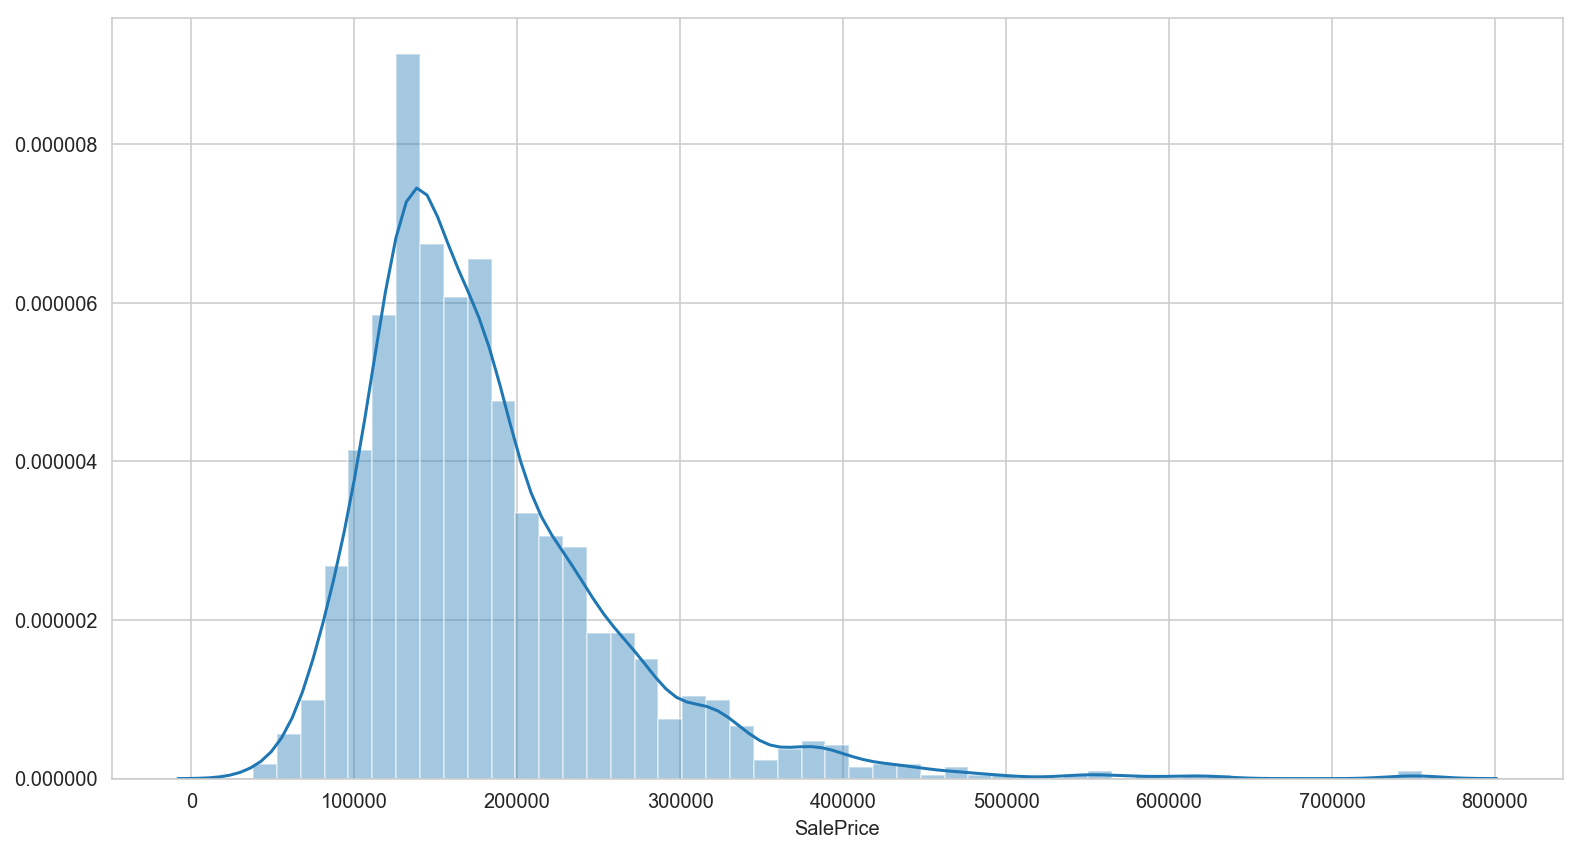

In [36]:
plt.figure(figsize=(13,7))
ax = sns.distplot(house["SalePrice"])

## Observations

* We did not remove outliers from the dataset. Hence, the target variable is positively skewed. 
* Let's log it to reduce the variability of our data.

In [37]:
house["SalePrice"] = np.log(house["SalePrice"])

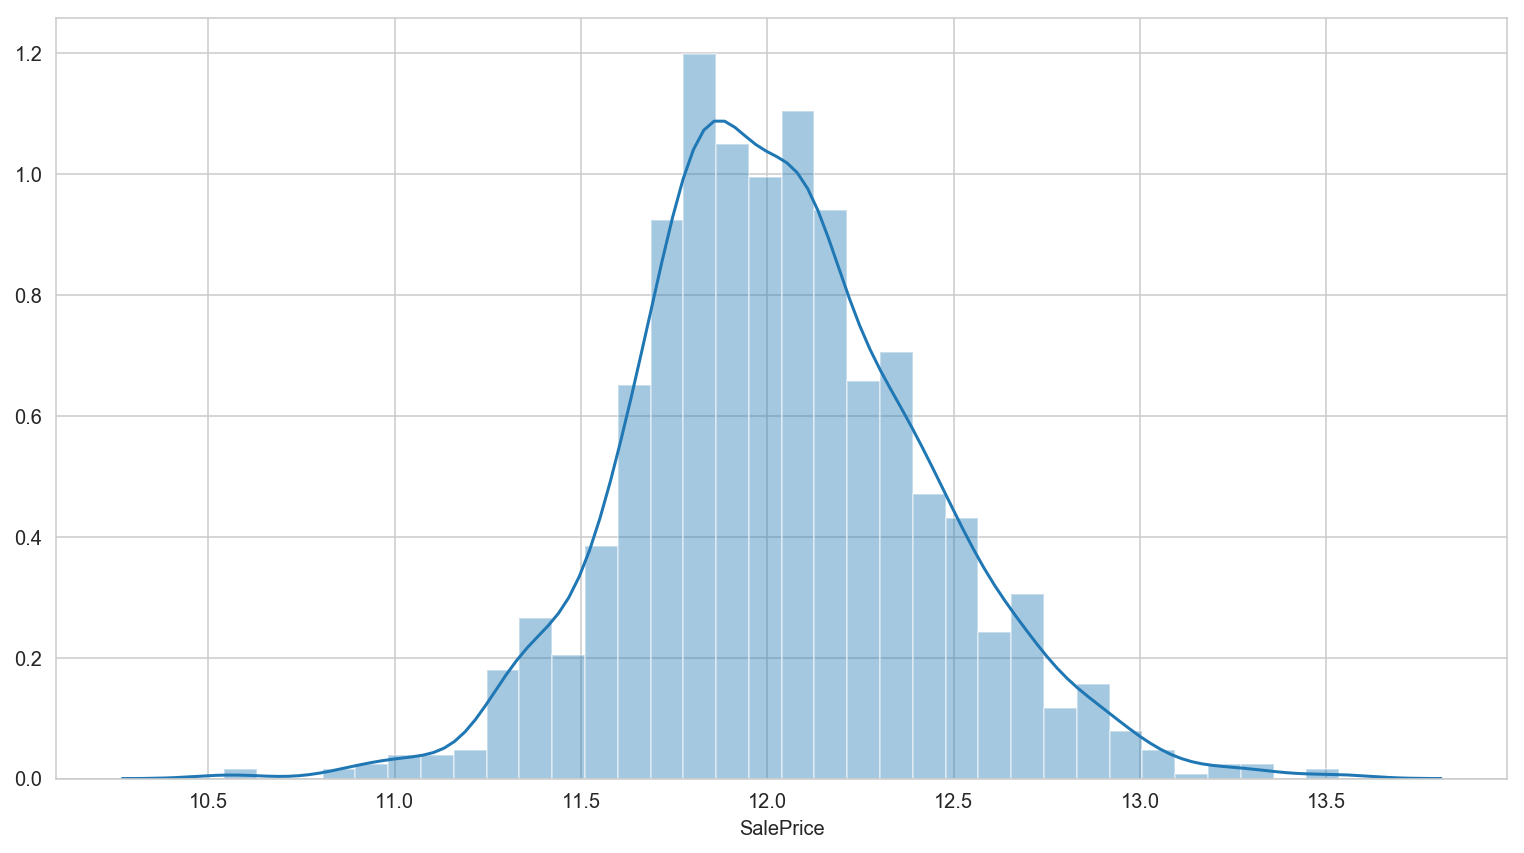

In [38]:
plt.figure(figsize=(13,7))
ax = sns.distplot(house["SalePrice"])

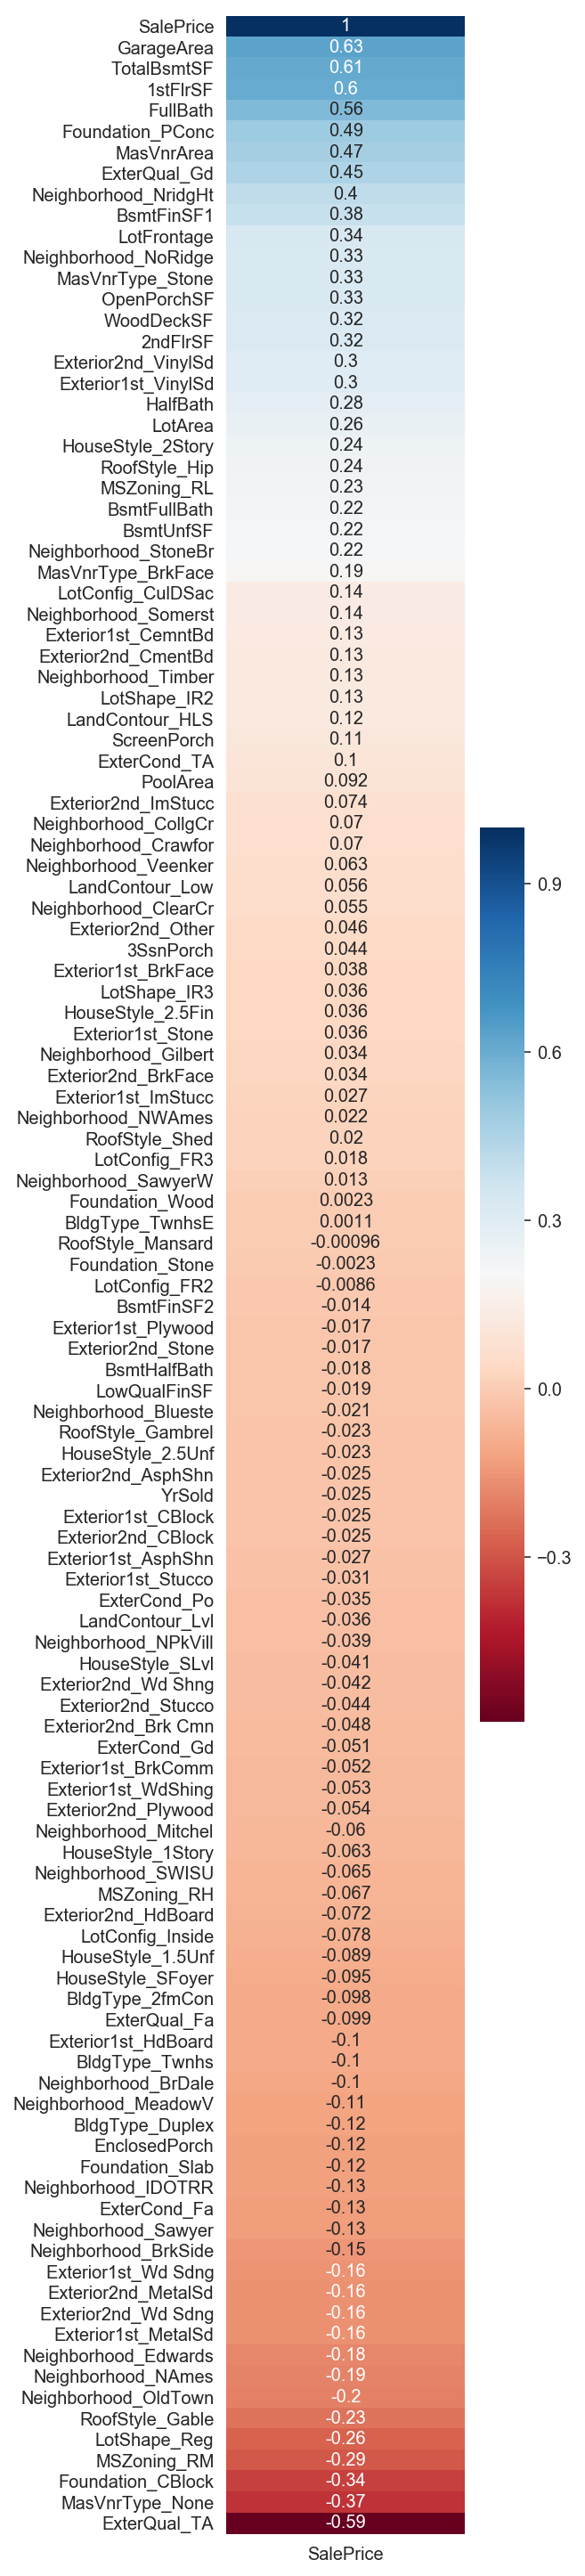

In [39]:
# Plot correlation map to have an overview of the correlation strength between X and y.
fix, ax = plt.subplots(figsize=(3,26))
sns.heatmap(house_f.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False), annot=True, cmap='RdBu')

## Observations

* The results are not surprising - certain neighbourhoods are correlated with SalePrice. 
* Other features such as the size of LotFrontage and LotArea, housing style and LotConfig are also correlated with the target variable. 
* These are the features that potential homeowners look into before making the purchase.
* As for the negatively correlated variables, we will leave them in the dataset and investigate further.
</div>

In [40]:
# Convert to string for boolean filtering.
house_f["YrSold"] = house_f["YrSold"].astype(str)

In [41]:
# Set up train and test sets.
train = house_f.loc[house_f['YrSold'] != '2010']
test = house_f.loc[house_f['YrSold'] == '2010']

In [42]:
train.shape

(1278, 120)

In [43]:
# X_train will contain predictors before 2010.
X_train = train.loc[:, ~train.columns.isin(['SalePrice', 'YrSold'])]

# y_train will contain the prices before 2010.
y_train = pd.DataFrame(train["SalePrice"].values)

# X_test wil contain predictors in 2010.
X_test = X_test = test.loc[:, ~test.columns.isin(['SalePrice', 'YrSold'])]

# # y_test will contain prices in 2010.
y_test = pd.DataFrame(test["SalePrice"].values)

In [44]:
print("Train & Test Shape:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Train & Test Shape:
X_train: (1278, 118)
y_train: (1278, 1)
X_test: (172, 118)
y_test: (172, 1)


In [45]:
# Standardize variables before linear regression with regularization.
ss = StandardScaler()
Xstd = pd.DataFrame(ss.fit_transform(X_train), columns=X_train.columns)
Xstd_test = pd.DataFrame(ss.transform(X_test))

## Observations

- Now that we have split the data into train and test, and standardize X_train, we can proceed to do our models.
- Let's start with StatsModels OLS on scaled data. </div>

In [46]:
# Run OLS on Xstd.
model = sm.OLS(y_train, Xstd, hasconst=True).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      0   R-squared:                      -4.454
Model:                            OLS   Adj. R-squared:                 -4.984
Method:                 Least Squares   F-statistic:                    -8.412
Date:                Fri, 18 Jan 2019   Prob (F-statistic):               1.00
Time:                        02:55:22   Log-Likelihood:                -17311.
No. Observations:                1278   AIC:                         3.485e+04
Df Residuals:                    1164   BIC:                         3.544e+04
Df Model:                         113                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
LotFrontage          -2233.3350   7975.884     -0.280      0.780   -1.79e+04    1.34e+04
LotArea               4670.5492   7362.937      0.634      0.526   -9775.563    1.91e+04
MasVnrArea            2732.1970   8873.748      0.308      0.758   -1.47e+04    2.01e+04
BsmtFinSF1            3101.2344   6711.678      0.462      0.644   -1.01e+04    1.63e+04
BsmtFinSF2             -66.7095   5868.305     -0.011      0.991   -1.16e+04    1.14e+04
BsmtUnfSF            -1070.4834   6179.355     -0.173      0.862   -1.32e+04    1.11e+04
TotalBsmtSF           2116.0838   9369.400      0.226      0.821   -1.63e+04    2.05e+04
1stFlrSF              2.148e+04   1.42e+04      1.518      0.129   -6284.654    4.92e+04
2ndFlrSF               3.09e+04   1.77e+04      1.741      0.082   -3919.957    6.57e+04
LowQualFinSF          1869.4671   7521.091      0.249      0.804   -1.29e+04    1.66e+04
BsmtFullBath          5423.5378   8423.516      0.644      0.520   -1.11e+04     2.2e+04
BsmtHalfBath          2067.7102   6132.961      0.337      0.736   -9965.185    1.41e+04
FullBath              5496.4546   9917.496      0.554      0.580    -1.4e+04     2.5e+04
HalfBath              4189.7442   8906.196      0.470      0.638   -1.33e+04    2.17e+04
GarageArea            5278.2990   7971.130      0.662      0.508   -1.04e+04    2.09e+04
WoodDeckSF            3193.6302   6284.329      0.508      0.611   -9136.249    1.55e+04
OpenPorchSF            390.6485   6596.997      0.059      0.953   -1.26e+04    1.33e+04
EnclosedPorch         -289.5680   6570.500     -0.044      0.965   -1.32e+04    1.26e+04
3SsnPorch             1388.9018   5758.417      0.241      0.809   -9909.136    1.27e+04
ScreenPorch           3323.6826   5855.184      0.568      0.570   -8164.212    1.48e+04
PoolArea              -103.7290   6022.126     -0.017      0.986   -1.19e+04    1.17e+04
MSZoning_RH           -673.5225   8543.582     -0.079      0.937   -1.74e+04    1.61e+04
MSZoning_RL           -610.5023   2.24e+04     -0.027      0.978   -4.46e+04    4.34e+04
MSZoning_RM           2045.5988   2.23e+04      0.092      0.927   -4.17e+04    4.58e+04
LotShape_IR2          1745.7702   6045.686      0.289      0.773   -1.01e+04    1.36e+04
LotShape_IR3         -3061.0074   6017.966     -0.509      0.611   -1.49e+04    8746.266
LotShape_Reg           -66.8242   6750.678     -0.010      0.992   -1.33e+04    1.32e+04
LandContour_HLS       5371.3950   8015.323      0.670      0.503   -1.04e+04    2.11e+04
LandContour_Low       2740.6146   7977.022      0.344      0.731   -1.29e+04    1.84e+04
LandContour_Lvl       4122.3178   9294.402      0.444      0.657   -1.41e+04    2.24e+04
LotConfig_CulDSac     2562.5464   6990.001      0.367      0.714   -1.12e+04    1.63e+04
LotConfig_FR2        -2396.8754   6272.059     -0.382    

## Observations
* OLS R2 scores do not make sense. Let's try SKLearn's Linear Regression on non-scaled values instead.

In [47]:
# Run linear regression.
linreg = LinearRegression()

linreg_scores = cross_val_score(linreg, X_train, y_train, cv=10)

print(linreg_scores)
print("Mean:",np.mean(linreg_scores))

[0.87486485 0.82730644 0.86488171 0.70286996 0.81041252 0.80505503
 0.81960356 0.7366704  0.51945071 0.86399223]
Mean: 0.7825107426061562


In [48]:
print("STD:",linreg_scores.std())

STD: 0.102111384443193


In [49]:
# Fit model using train data.
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [50]:
# Score the fitted model using test data.
linreg.score(X_test, y_test)

0.8482281925580899

## Observations
* Linear regression on non-scaled data performed way better than OLS.
* This will be the baseline.
* Now let's try ridge regression (with scaled data).

In [51]:
# Obtain the optimal alpha for ridge regression.
ridge_alphas = np.logspace(-2, 7, 50)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xstd, y_train)

print(optimal_ridge.alpha_)

71.96856730011521


In [52]:
# Run ridge regression.
ridge = Ridge(alpha=optimal_ridge.alpha_)
ridge_scores = cross_val_score(ridge, Xstd, y_train, cv=10)

print(ridge_scores)
print("Mean:", np.mean(ridge_scores))
print("STD:",ridge_scores.std())

[0.88409743 0.81802213 0.85869083 0.7263824  0.79519576 0.80003565
 0.85244132 0.76517806 0.50732123 0.8590828 ]
Mean: 0.786644761009384
STD: 0.10373769581939174


In [53]:
# Fit model using train data
ridge.fit(Xstd, y_train)

Ridge(alpha=71.96856730011521, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [54]:
# Score the fitted model using test data.
ridge.score(Xstd_test, y_test)

0.8463865638625235

In [55]:
print("R2 Scores So Far...")
print("Linear regression:", linreg.score(X_test, y_test))
print("Ridge regression:", ridge.score(Xstd_test, y_test))

R2 Scores So Far...
Linear regression: 0.8482281925580899
Ridge regression: 0.8463865638625235


## Observations
- Ridge regression performed slightly better than linear regression.
- Now let's try lasso regression (with scaled data).

In [56]:
# Obtain the optimal alpha for lasso regression.
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xstd, y_train)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

489.88012372639014


.................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.1s finished


In [57]:
# Run lasso regression.
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, Xstd, y_train, cv=10)

print(lasso_scores)
print("Mean:", np.mean(lasso_scores))
print("STD:", lasso_scores.std())

[0.88188001 0.83177237 0.85751554 0.72378352 0.79875036 0.8201805
 0.86167442 0.75636112 0.5076829  0.86834475]
Mean: 0.7907945491290195
STD: 0.10593422348232644


In [58]:
# Find the % of variables zeroed out.
print('Percent variables zeroed out:', np.sum((optimal_lasso.coef_ == 0))/float(len(optimal_lasso.coef_)))

Percent variables zeroed out: 0.3305084745762712


In [59]:
# Fit model using train data.
lasso.fit(Xstd, y_train)

Lasso(alpha=489.88012372639014, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [60]:
# Score the fitted model using test data.
lasso.score(Xstd_test, y_test)

0.8518974269260728

In [61]:
# Print coefficients from lasso regression.
lasso_coefs = pd.DataFrame({'variable':Xstd.columns,
                            'coef':lasso.coef_})

lasso_coefs.sort_values('coef', inplace=True, ascending=False)

lasso_coefs

,variable,coef
8,2ndFlrSF,21311.481428
7,1stFlrSF,21124.299732
49,Neighborhood_NridgHt,13503.399965
48,Neighborhood_NoRidge,8700.053238
55,Neighborhood_StoneBr,8035.889480
14,GarageArea,6698.471276
12,FullBath,6088.046820
54,Neighborhood_Somerst,4976.228498
10,BsmtFullBath,4657.987633
3,BsmtFinSF1,3911.386038


In [62]:
print("R2 Scores So Far...")
print("Linear regression:", linreg.score(X_test, y_test))
print("Ridge regression:", ridge.score(Xstd_test, y_test))
print("Lasso regression:", lasso.score(Xstd_test, y_test))

R2 Scores So Far...
Linear regression: 0.8482281925580899
Ridge regression: 0.8463865638625235
Lasso regression: 0.8518974269260728


## Observations
* Lasso regression on scaled data performed better than linear regression.
* However, the highly negatively correlated variables were not zeroed out by the model.
* A possible reason may be due to the low lambda (is our optimal alpha really the best?).
* Now let's try elastic net regression (with scaled data).

In [63]:
# Obtain the optimal alpha for elastic net regression.
l1_ratios = np.linspace(0.01, 1.0, 25)
optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=500, cv=10)
optimal_enet.fit(Xstd, y_train)

print("Optimal alpha:", optimal_enet.alpha_)
print("Optimal ratio:", optimal_enet.l1_ratio_)

Optimal alpha: 489.88012372639014
Optimal ratio: 1.0


In [64]:
# Run elastic net regression.
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, Xstd, y_train, cv=20)

print(enet_scores)
print("Mean:", np.mean(enet_scores))
print("STD:",enet_scores.std())

[ 0.89481319  0.85447804  0.81645661  0.85837113  0.85095754  0.86477314
  0.89466849  0.51007471  0.86301513  0.77177022  0.82952613  0.78333035
  0.84509859  0.88800593  0.76297209  0.76515794  0.70397583 -0.44605302
  0.86365372  0.87659986]
Mean: 0.7525822807227038
STD: 0.28814468510553537


In [65]:
enet.fit(Xstd, y_train)

ElasticNet(alpha=489.88012372639014, copy_X=True, fit_intercept=True,
      l1_ratio=1.0, max_iter=1000, normalize=False, positive=False,
      precompute=False, random_state=None, selection='cyclic', tol=0.0001,
      warm_start=False)

In [66]:
enet.score(Xstd_test, y_test)

0.8518974269260728

In [67]:
# Print coefficients from our elastic net model.
df_coef = pd.DataFrame(enet.coef_, columns=['coef'])

df_coef['names'] = X_train.columns
df_coef['abs coef'] = np.abs(df_coef['coef'])

df_coef.sort_values('abs coef',ascending=False)

,coef,names,abs coef
108,-21545.518097,ExterQual_TA,21545.518097
8,21311.481428,2ndFlrSF,21311.481428
7,21124.299732,1stFlrSF,21124.299732
49,13503.399965,Neighborhood_NridgHt,13503.399965
107,-12310.051957,ExterQual_Gd,12310.051957
48,8700.053238,Neighborhood_NoRidge,8700.053238
55,8035.889480,Neighborhood_StoneBr,8035.889480
14,6698.471276,GarageArea,6698.471276
12,6088.046820,FullBath,6088.046820
59,-5186.311410,BldgType_Duplex,5186.311410


In [68]:
print("R2 Scores So Far...")
print("Linear regression:", linreg.score(X_test, y_test))
print("Ridge regression:", ridge.score(Xstd_test, y_test))
print("Lasso regression:", lasso.score(Xstd_test, y_test))
print("Elastic net regression:", enet.score(Xstd_test, y_test))

R2 Scores So Far...
Linear regression: 0.8482281925580899
Ridge regression: 0.8463865638625235
Lasso regression: 0.8518974269260728
Elastic net regression: 0.8518974269260728


## Observations
- Elastic net regression on scaled data performed just as well as lasso regression.
* The model zeroed out the useless variables which lasso did not.
- Lastly, let's try random forest (with unscaled data).

In [69]:
# Create the parameter grid.
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [70]:
# Run Random Forest.
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [71]:
# Fit model using train data.
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [72]:
# Score the fitted model using test data.
rf.score(X_test, y_test)

0.8326442615966325

In [73]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

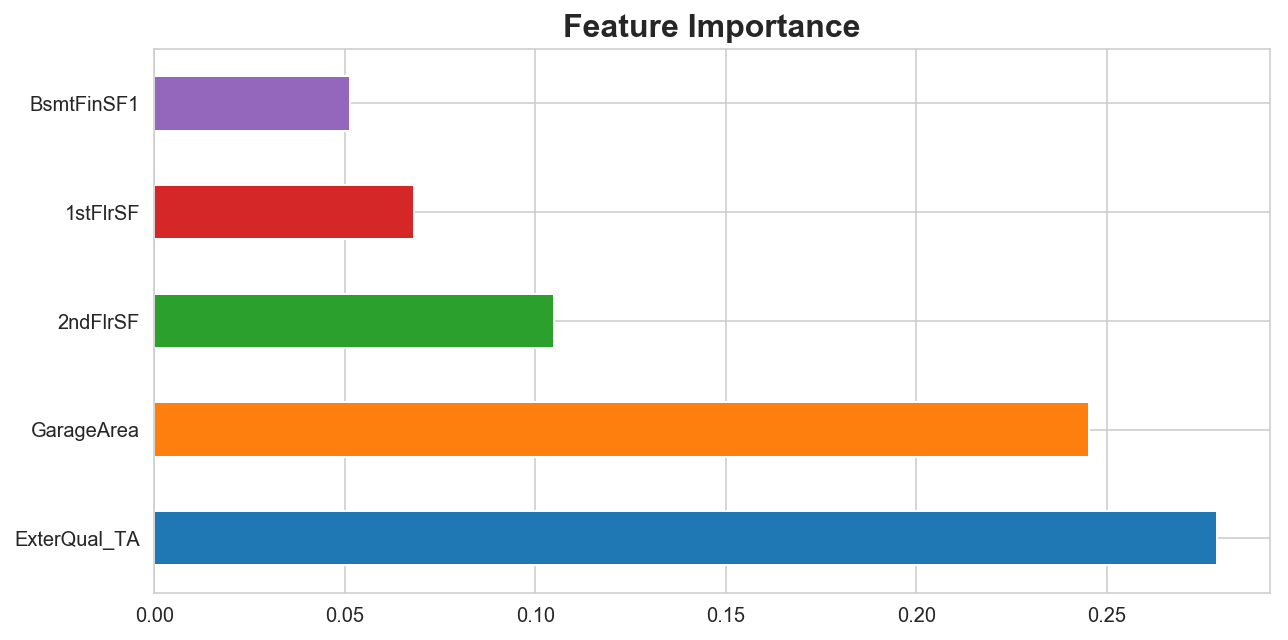

In [74]:
plt.figure(figsize=(10,5))
# plt.xlabel('Importance')
# plt.ylabel('Feature')
plt.title('Feature Importance',fontsize=16,fontweight='bold')
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5).plot(kind='barh')

In [75]:
print("R2 Scores So Far...")
print("Linear regression:", linreg.score(X_test, y_test))
print("Ridge regression:", ridge.score(Xstd_test, y_test))
print("Lasso regression:", lasso.score(Xstd_test, y_test))
print("Elastic net regression:", enet.score(Xstd_test, y_test))
print("Random forest:", rf.score(X_test, y_test))

R2 Scores So Far...
Linear regression: 0.8482281925580899
Ridge regression: 0.8463865638625235
Lasso regression: 0.8518974269260728
Elastic net regression: 0.8518974269260728
Random forest: 0.8326442615966325


## Observations
- Random forest did not score as well as the rest of the models.
- The best model is lasso and elastic net.

<div class="alert alert-warning">

## Top 5 Correlated Features

After cleaning, EDA and modelling, we've found the top five fixed features that influence potential homeowners:
    1. 2ndFlrSF	 
    2. 1stFlrSF
    3. Neighborhood_NridgHt
    4. Neighborhood_NoRidge
    5. Neighborhood_StoneBr

This makes perfect sense. Future homeowners will look into the size of the house to fit their families. Hence, the square feet area of first and second levels are important to them. They neighbourhoods also play a part in their decision process. It seems that these neighbourhoods are the most popular. Perhaps there are many amenities within walking distance from their homes or more good schools or government institutions around the area. But that will be a different research and analysis for another day.
</div>

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [76]:
house_r = house[["BsmtQual_Fa", "BsmtQual_Gd", "BsmtQual_TA", "BsmtCond_Gd", "BsmtCond_Po", 
            "BsmtCond_TA", "BsmtExposure_Gd", "BsmtExposure_Mn", "BsmtExposure_No", "BsmtFinType1_BLQ",
            "BsmtFinType1_GLQ", "BsmtFinType1_LwQ", "BsmtFinType1_Rec", "BsmtFinType1_Unf", "BsmtFinType2_BLQ",
            "BsmtFinType2_GLQ", "BsmtFinType2_LwQ", "BsmtFinType2_Rec", "BsmtFinType2_Unf", "HeatingQC_Fa",
            "HeatingQC_Gd", "HeatingQC_Po", "HeatingQC_TA", "Electrical_FuseF", "Electrical_FuseP", 
            "Electrical_Mix", "Electrical_SBrkr", "KitchenQual_Fa", "KitchenQual_Gd", "KitchenQual_TA",
            "Functional_Maj2", "Functional_Min1", "Functional_Min2", "Functional_Mod", "Functional_Sev", 
            "Functional_Typ", "FireplaceQu_Fa", "FireplaceQu_Gd", "FireplaceQu_Po", "FireplaceQu_TA",
            "GarageType_Attchd", "GarageType_Basment", "GarageType_BuiltIn", "GarageType_CarPort", "GarageType_Detchd", 
            "GarageFinish_RFn", "GarageFinish_Unf", "GarageQual_Fa", "GarageQual_Gd", "GarageQual_Po",
            "GarageQual_TA", "GarageCond_Fa", "GarageCond_Gd", "GarageCond_Po", "GarageCond_TA",
            "PavedDrive_P", "PavedDrive_Y", "SaleType_CWD", "SaleType_Con", "SaleType_ConLD", 
            "SaleType_ConLI", "SaleType_ConLw", "SaleType_New", "SaleType_Oth", "SaleType_WD", 
            "SaleCondition_AdjLand", "SaleCondition_Alloca", "SaleCondition_Family", "SaleCondition_Normal", "SaleCondition_Partial",
            "MSSubClass_160", "MSSubClass_180", "MSSubClass_190", "MSSubClass_20", "MSSubClass_30",
            "MSSubClass_40", "MSSubClass_45", "MSSubClass_50", "MSSubClass_60", "MSSubClass_70",
            "MSSubClass_75", "MSSubClass_80", "MSSubClass_85", "MSSubClass_90", "Fireplaces_1",
            "Fireplaces_2", "Fireplaces_3", "GarageCars_1", "GarageCars_2", "GarageCars_3", "GarageCars_4",
            "YrSold", "SalePrice"]]

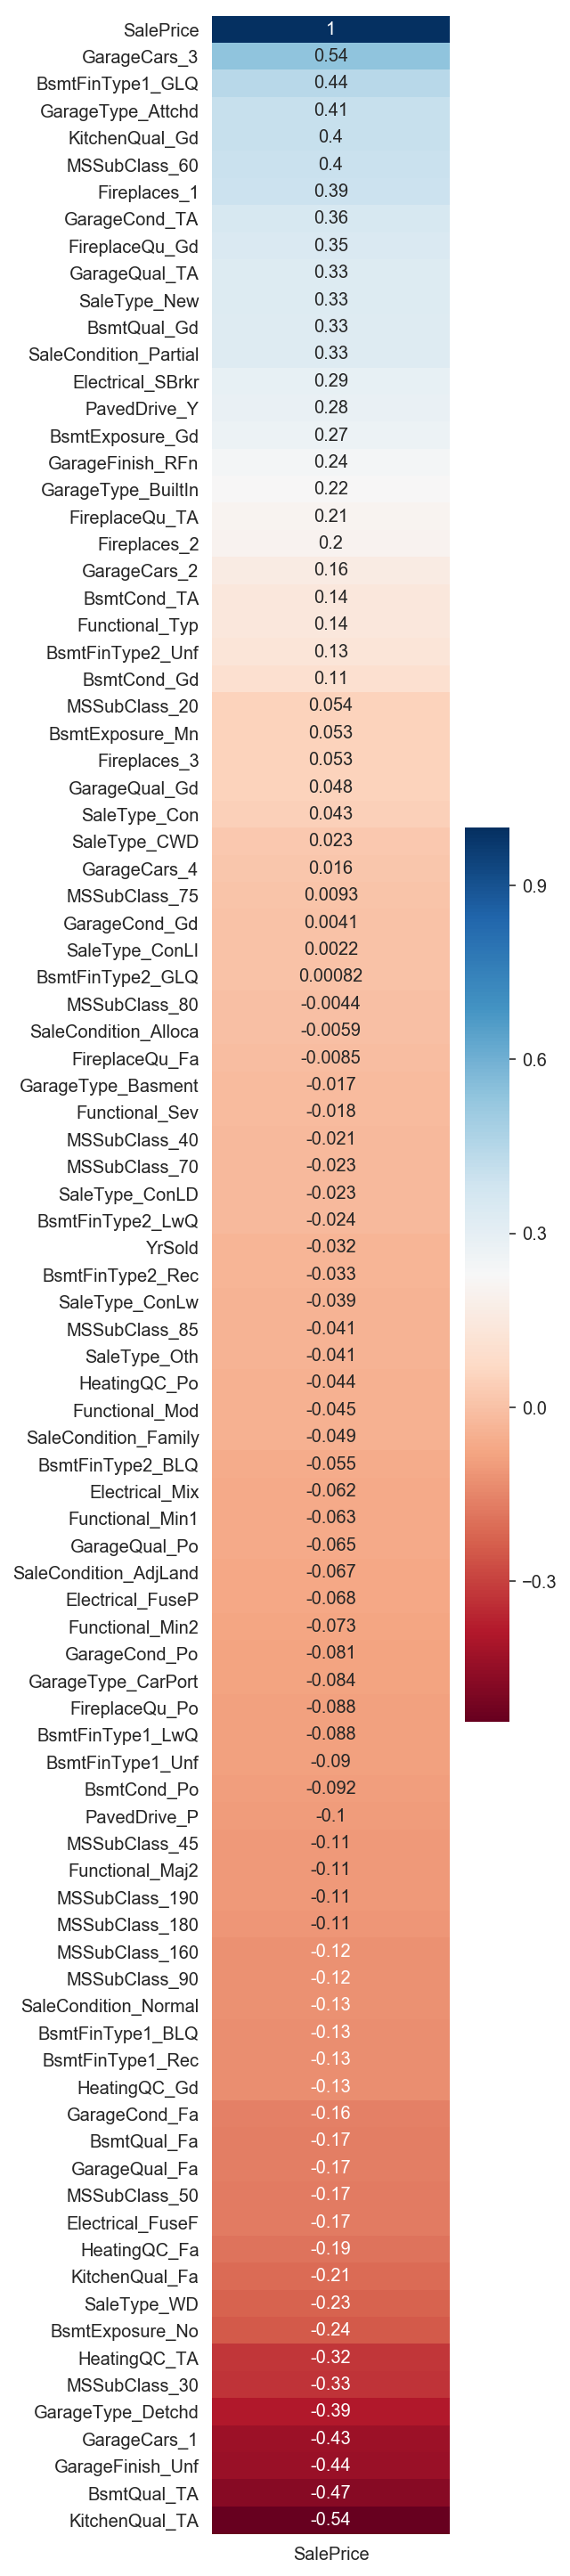

In [77]:
# Plot correlation map to have an overview of the correlation strength between X and y.
fix, ax = plt.subplots(figsize=(3,26))
sns.heatmap(house_r.corr()[['SalePrice']].sort_values(by='SalePrice', ascending=False), annot=True, cmap='RdBu')

## Observations

* Garage size and type, basement finish type, kitchen quality and the type of house are strongly correlated with SalePrice.
* Other features such as number of fireplace and garage quality are also correlated with the target variable. 
* As for the negatively correlated variables, we will leave them in the dataset and investigate further.
</div>

In [78]:
# Convert to string for boolean filtering.
house_r["YrSold"] = house_r["YrSold"].astype(str)

In [79]:
# Set up train and test sets.
train = house_r.loc[house_r['YrSold'] != '2010']
test = house_r.loc[house_r['YrSold'] == '2010']

In [80]:
train.shape

(1278, 93)

In [81]:
# X_train will contain predictors before 2010.
X_train = train.loc[:, ~train.columns.isin(['SalePrice', 'YrSold'])]

# y_train will contain the prices before 2010.
y_train = pd.DataFrame(train["SalePrice"].values)

# X_test wil contain predictors in 2010.
X_test = X_test = test.loc[:, ~test.columns.isin(['SalePrice', 'YrSold'])]

# # y_test will contain prices in 2010.
y_test = pd.DataFrame(test["SalePrice"].values)

In [82]:
print("Train & Test Shape:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Train & Test Shape:
X_train: (1278, 91)
y_train: (1278, 1)
X_test: (172, 91)
y_test: (172, 1)


In [83]:
# Standardize variables before linear regression with regularization.
ss = StandardScaler()
# Xstd = pd.DataFrame(ss.fit_transform(X_train, X_test), columns=train.columns)
Xstd = pd.DataFrame(ss.fit_transform(X_train), columns=X_train.columns)
Xstd_test = pd.DataFrame(ss.transform(X_test))

## Observations

- Now that we have split the data into train and test, and standardize X_train, we can proceed to do our models.
- Let's start with StatsModels OLS on scaled data. </div>

In [84]:
# Run OLS on Xstd.
model = sm.OLS(y_train, Xstd, hasconst=True).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      0   R-squared:                    -944.553
Model:                            OLS   Adj. R-squared:              -1016.246
Method:                 Least Squares   F-statistic:                    -13.17
Date:                Fri, 18 Jan 2019   Prob (F-statistic):               1.00
Time:                        02:55:49   Log-Likelihood:                -4992.7
No. Observations:                1278   AIC:                         1.017e+04
Df Residuals:                    1187   BIC:                         1.064e+04
Df Model:                          90                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
BsmtQual_Fa              -0.0283      0.485     -0.058      0.953      -0.979       0.923
BsmtQual_Gd              -0.0389      0.803     -0.048      0.961      -1.615       1.538
BsmtQual_TA              -0.0780      0.929     -0.084      0.933      -1.901       1.745
BsmtCond_Gd               0.0360      0.550      0.065      0.948      -1.043       1.115
BsmtCond_Po              -0.0143      0.546     -0.026      0.979      -1.085       1.056
BsmtCond_TA               0.0438      0.629      0.070      0.944      -1.190       1.278
BsmtExposure_Gd           0.0369      0.449      0.082      0.934      -0.844       0.918
BsmtExposure_Mn           0.0062      0.444      0.014      0.989      -0.865       0.878
BsmtExposure_No           0.0040      0.554      0.007      0.994      -1.083       1.091
BsmtFinType1_BLQ          0.0049      0.453      0.011      0.991      -0.884       0.894
BsmtFinType1_GLQ          0.0209      0.581      0.036      0.971      -1.118       1.160
BsmtFinType1_LwQ          0.0086      0.415      0.021      0.983      -0.805       0.822
BsmtFinType1_Rec          0.0073      0.443      0.017      0.987      -0.862       0.877
BsmtFinType1_Unf         -0.0180      0.570     -0.032      0.975      -1.137       1.101
BsmtFinType2_BLQ          0.0113      0.510      0.022      0.982      -0.989       1.012
BsmtFinType2_GLQ          0.0115      0.427      0.027      0.979      -0.826       0.849
BsmtFinType2_LwQ          0.0287      0.565      0.051      0.959      -1.080       1.138
BsmtFinType2_Rec          0.0291      0.578      0.050      0.960      -1.105       1.163
BsmtFinType2_Unf          0.0410      0.861      0.048      0.962      -1.647       1.729
HeatingQC_Fa             -0.0298      0.400     -0.075      0.941      -0.814       0.755
HeatingQC_Gd             -0.0155      0.408     -0.038      0.970      -0.817       0.786
HeatingQC_Po             -0.0077      0.378     -0.020      0.984      -0.749       0.734
HeatingQC_TA             -0.0266      0.474     -0.056      0.955      -0.957       0.904
Electrical_FuseF         -0.0114      0.420     -0.027      0.978      -0.835       0.813
Electrical_FuseP         -0.0083      0.431     -0.019      0.985      -0.854       0.837
Electrical_Mix            0.0077      0.622      0.012      0.990      -1.213       1.228
Electrical_SBrkr         -0.0035      0.450     -0.008      0.994      -0.887       0.880
KitchenQual_Fa           -0.0425      0.493     -0.086      0.931      -1.010       0.925
KitchenQual_Gd           -0.0805      0.849     -0.095      0.925      -1.747       1.586
KitchenQual_TA           -0.1408      0.950     -0.148      0.882      -2.005       1.724
Functional_Maj2          -0.0153      0.461     -0.033      0.973      -0.919       0.888
Functional_Min1        

## Observations
* OLS R2 scores do not make sense. Let's try non-scaled values instead.

In [85]:
# Run linear regression.
linreg = LinearRegression()

linreg_scores = cross_val_score(linreg, X_train, y_train, cv=10)

print(linreg_scores)
print("Mean:",np.mean(linreg_scores))
print("STD:",linreg_scores.std())

[ 7.67609506e-01 -3.66024983e+21 -3.26677571e+24  7.14815093e-01
  7.78211898e-01  7.28768658e-01  7.32910303e-01  7.99726562e-01
  7.33861921e-01  7.81117935e-01]
Mean: -3.270435963765031e+23
STD: 9.799113135018172e+23


In [86]:
# Fit model using train data
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [87]:
# Score the fitted model using test data.
linreg.score(X_test, y_test)

0.8121407798049173

## Observations
* Linear regression performance on training data was bad. We'd expect the results on test set to be similar. However, the model on the test set performed well. Why is that so?
* Now let's try ridge regression (with scaled data).

In [88]:
# Obtain the optimal alpha for ridge regression.
ridge_alphas = np.logspace(-2, 7, 50)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xstd, y_train)

print(optimal_ridge.alpha_)

13.257113655901096


In [89]:
# Run ridge regression.
ridge = Ridge(alpha=optimal_ridge.alpha_)
ridge_scores = cross_val_score(ridge, Xstd, y_train, cv=10)

print(ridge_scores)
print("Mean:", np.mean(ridge_scores))
print("STD:",ridge_scores.std())

[0.7752472  0.80556693 0.80773856 0.71791155 0.78192863 0.72452593
 0.73613646 0.80728279 0.73264314 0.7812844 ]
Mean: 0.767026558163217
STD: 0.03407540722844484


In [90]:
# Fit model using train data.
ridge.fit(Xstd, y_train)

Ridge(alpha=13.257113655901096, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

In [91]:
# Score the fitted model using test data.
ridge.score(Xstd_test, y_test)

0.8117971804013571

In [92]:
print("R2 Scores So Far...")
print("Linear regression:", linreg.score(X_test, y_test))
print("Ridge regression:", ridge.score(Xstd_test, y_test))

R2 Scores So Far...
Linear regression: 0.8121407798049173
Ridge regression: 0.8117971804013571


## Observations
- Ridge regression scores on scaled data fell slightly shorter than linear regression.
- Now let's try lasso regression (with scaled data).

In [93]:
# Obtain the optimal alpha for lasso regression.
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xstd, y_train)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.0008550206420289207


...................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.6s finished


In [94]:
# Run lasso regression.
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, Xstd, y_train, cv=10)

print(lasso_scores)
print("Mean:", np.mean(lasso_scores))
print("STD:", lasso_scores.std())

[0.77678397 0.8061032  0.81100023 0.71760059 0.77908511 0.73032434
 0.73885516 0.80898349 0.73216506 0.78402845]
Mean: 0.7684929599711702
STD: 0.03395314246977288


In [95]:
# Find the % of variables zeroed out.
print('Percent variables zeroed out:', np.sum((optimal_lasso.coef_ == 0))/float(len(optimal_lasso.coef_)))

Percent variables zeroed out: 0.08791208791208792


In [96]:
# Fit model using train data.
lasso.fit(Xstd, y_train)

Lasso(alpha=0.0008550206420289207, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [97]:
# Score the fitted model using test data.
lasso.score(Xstd_test, y_test)

0.8130364808085153

In [98]:
# Print coefficients from lasso regression.
lasso_coefs = pd.DataFrame({'variable':Xstd.columns,
                            'coef':lasso.coef_})

lasso_coefs.sort_values('coef', inplace=True, ascending=False)

lasso_coefs

,variable,coef
89,GarageCars_3,0.109072
78,MSSubClass_60,0.067011
84,Fireplaces_1,0.065169
85,Fireplaces_2,0.059611
88,GarageCars_2,0.059374
40,GarageType_Attchd,0.048668
79,MSSubClass_70,0.047314
5,BsmtCond_TA,0.044082
73,MSSubClass_20,0.041146
6,BsmtExposure_Gd,0.035536


In [99]:
print("R2 Scores So Far...")
print("Linear regression:", linreg.score(X_test, y_test))
print("Ridge regression:", ridge.score(Xstd_test, y_test))
print("Lasso regression:", lasso.score(Xstd_test, y_test))

R2 Scores So Far...
Linear regression: 0.8121407798049173
Ridge regression: 0.8117971804013571
Lasso regression: 0.8130364808085153


## Observations
* Lasso regression on scaled data performed better than linear regression.
* Like in Q1, the highly negatively correlated variables were not zeroed out by the model.
* Now let's try elastic net regression (with scaled data).

In [100]:
# Obtain the optimal alpha for elastic net regression.
l1_ratios = np.linspace(0.01, 1.0, 25)
optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=500, cv=10)
optimal_enet.fit(Xstd, y_train)

print("Optimal alpha:", optimal_enet.alpha_)
print("Optimal ratio:", optimal_enet.l1_ratio_)

Optimal alpha: 0.0008550206420289207
Optimal ratio: 1.0


In [101]:
# Run elastic net regression.
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, Xstd, y_train, cv=20)

print(enet_scores)
print(np.mean(enet_scores))
print(np.std(enet_scores))

[0.81441551 0.72175309 0.78918277 0.8227051  0.78107869 0.81856421
 0.69679939 0.72295654 0.71508687 0.81945521 0.78867877 0.6457802
 0.72999504 0.75168286 0.81519822 0.79348932 0.76832243 0.66523488
 0.78136159 0.77558115]
0.760866092549757
0.05135193612824446


In [102]:
# Fit model using train data.
enet.fit(Xstd, y_train)

ElasticNet(alpha=0.0008550206420289207, copy_X=True, fit_intercept=True,
      l1_ratio=1.0, max_iter=1000, normalize=False, positive=False,
      precompute=False, random_state=None, selection='cyclic', tol=0.0001,
      warm_start=False)

In [103]:
# Score the fitted model using test data.
enet.score(Xstd_test, y_test)

0.8130364808085153

In [104]:
# Print coefficients from our elastic net model.
df_coef = pd.DataFrame(enet.coef_, columns=['coef'])

df_coef['names'] = X_train.columns
df_coef['abs coef'] = np.abs(df_coef['coef'])

df_coef.sort_values('abs coef',ascending=False)

,coef,names,abs coef
29,-0.140841,KitchenQual_TA,0.140841
89,0.109072,GarageCars_3,0.109072
28,-0.079922,KitchenQual_Gd,0.079922
2,-0.067912,BsmtQual_TA,0.067912
78,0.067011,MSSubClass_60,0.067011
84,0.065169,Fireplaces_1,0.065169
85,0.059611,Fireplaces_2,0.059611
88,0.059374,GarageCars_2,0.059374
40,0.048668,GarageType_Attchd,0.048668
79,0.047314,MSSubClass_70,0.047314


In [105]:
print("R2 Scores So Far...")
print("Linear regression:", linreg.score(X_test, y_test))
print("Ridge regression:", ridge.score(Xstd_test, y_test))
print("Lasso regression:", lasso.score(Xstd_test, y_test))
print("Elastic net regression:", enet.score(Xstd_test, y_test))

R2 Scores So Far...
Linear regression: 0.8121407798049173
Ridge regression: 0.8117971804013571
Lasso regression: 0.8130364808085153
Elastic net regression: 0.8130364808085153


## Observations
- Elastic net regression on scaled data performed just as well as lasso regression.
* The model zeroed out the useless variables which lasso did not.
- Lastly, let's try random forest (with unscaled data).

In [106]:
# Create the parameter grid.
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [107]:
# Run random forest.
rf = RandomForestRegressor()

# Instantiate the grid search model.
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [108]:
# Fit model using train data.
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [109]:
# Score the fitted model using test data.
rf.fit(X_test, y_test)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [110]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

<Figure size 720x360 with 0 Axes>

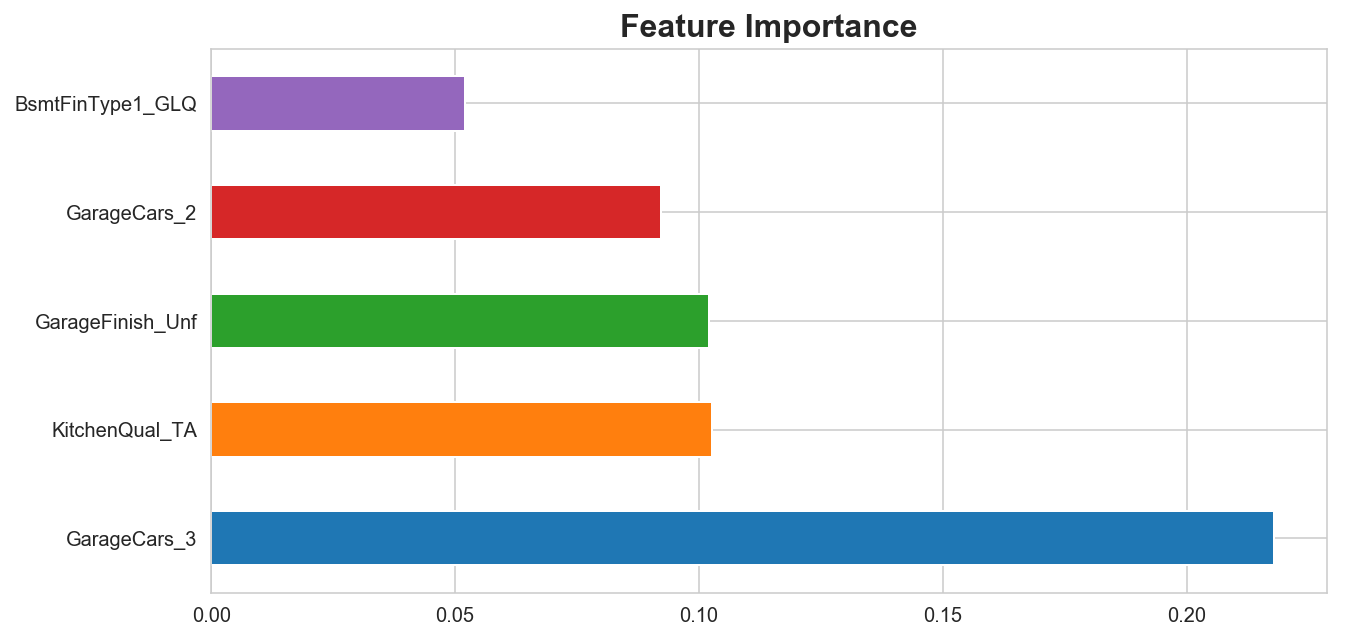

In [111]:
plt.figure(figsize=(10,5))
plt.figure(figsize=(10,5))
# plt.xlabel('Importance')
# plt.ylabel('Feature')
plt.title('Feature Importance',fontsize=16,fontweight='bold')
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5).plot(kind='barh')

In [112]:
print("R2 Scores So Far...")
print("Linear regression:", linreg.score(X_test, y_test))
print("Ridge regression:", ridge.score(Xstd_test, y_test))
print("Lasso regression:", lasso.score(Xstd_test, y_test))
print("Elastic net regression:", enet.score(Xstd_test, y_test))
print("Random forest:", rf.score(X_test, y_test))

R2 Scores So Far...
Linear regression: 0.8121407798049173
Ridge regression: 0.8117971804013571
Lasso regression: 0.8130364808085153
Elastic net regression: 0.8130364808085153
Random forest: 0.9416075333630911


## Observations
- Random forest tops the scores by a huge margin. Is our model overfitting the data? Possibly.

<div class="alert alert-warning">

## Top 5 Correlated Features

After cleaning, EDA and modelling, we've found the top five fixed features that influence potential homeowners:
    1. KitchenQual_TA
    2. GarageCars_3
    3. BsmtFinType1_GLQ
    4. GarageCars_2
    5. GarageFinish_Unf

It's interesting to see property prices determined by the kitchen, garage and basement, instead of number of rooms and bathrooms. The results may not be accurate though - there is a possibility the model is overfitting the data. 
</div>

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.